In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsFinalDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
noise_type='other'

In [3]:
# Dataset
datapath = Path('data')

dataset_noRE = TsFinalDataset(datapath/'CaseI-Attacks without any change.csv', noise_type="none")
dataset_RE = TsFinalDataset(datapath/'CaseII.csv', noise_type='none')

data_normal_noRE = dataset_noRE.data_normal
data_attacked_noRE = dataset_noRE.data_attacked

data_normal_RE = dataset_RE.data_normal
data_attacked_RE = dataset_RE.data_attacked

data_normal_noRE.size(), data_attacked_noRE.size(), data_normal_RE.size(), data_attacked_RE.size()

(torch.Size([15, 2045, 33]),
 torch.Size([15, 2045, 33]),
 torch.Size([15, 1973, 33]),
 torch.Size([15, 1973, 33]))

In [4]:
normal_seq_len = dataset_noRE.data_normal.size(1)
normal_feature_len = dataset_noRE.data_normal.size(2)
attacked_seq_len = dataset_noRE.data_attacked.size(1)
attacked_feature_len = dataset_noRE.data_attacked.size(2)

G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(attacked_seq_len, attacked_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

G_AB.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_AB_190.pth"))
G_BA.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_BA_190.pth"))
D_A.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_A_190.pth"))
D_B.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_B_190.pth"))

G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(33, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=33, bias=True)
    (1): Sigmoid()
  )
)

# Experiment on Normal (RE)

In [5]:
with torch.no_grad():
    output = G_AB(data_normal_RE)
    output_back = G_BA(output)
    print(D_A(data_normal_RE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_normal_RE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9699) tensor(0.9685) tensor(0.9688)
tensor(0.0365) tensor(0.0365) tensor(0.0370)
Output size: torch.Size([15, 1973, 33]) 	 Output Back size: torch.Size([15, 1973, 33])


In [6]:
os.makedirs(f'cyber_result/true_L1/{noise_type}/NormalRE', exist_ok=True)
NormalRE_res_list = []

for i in range(output.size(0)):
    for feature_number in range(output.size(2)):
        plt.plot(output[i, :, feature_number].numpy())
        plt.plot(output_back[i, :, feature_number].numpy())
        plt.plot(data_normal_RE[i, :, feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Normal data with RE'])
        plt.savefig(f'cyber_result/true_L1/{noise_type}/NormalRE/output_{i}_feature{feature_number}.png')
        plt.close()
    dist1 = torch.mean(np.abs(data_normal_RE[i] - output[i]))
    dist2 = torch.mean(np.abs(output[i] - output_back[i]))
    dist3 = torch.mean(np.abs(output_back[i] - data_normal_RE[i]))
    res = (dist2+dist3)/dist1
    NormalRE_res_list.append(res)
    print(i, res, dist1, dist2, dist3)

0 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
1 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
2 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
3 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
4 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
5 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
6 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
7 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
8 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
9 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
10 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
11 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
12 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
13 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)
14 tensor(1.1028) tensor(0.2127) tensor(0.2086) tensor(0.0260)


In [7]:
plt.figure()
# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Normal data with RE')
plt.savefig(f'cyber_result/true_L1/{noise_type}/NormalRE.png')
plt.close()

---

# Experiment on Attacked (RE)

In [8]:
data_attacked_RE.size()

torch.Size([15, 1973, 33])

In [9]:
with torch.no_grad():
    output = G_AB(data_attacked_RE)
    output_back = G_BA(output)
    print(D_A(data_attacked_RE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_attacked_RE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9694) tensor(0.9686) tensor(0.9689)
tensor(0.0380) tensor(0.0368) tensor(0.0370)
Output size: torch.Size([15, 1973, 33]) 	 Output Back size: torch.Size([15, 1973, 33])


In [10]:
os.makedirs(f'cyber_result/true_L1/{noise_type}/AttackedRE', exist_ok=True)
AttackedRE_res_list = []

for i in range(output.size(0)):
    for feature_number in range(output.size(2)):
        plt.plot(output[i,:,feature_number].numpy())
        plt.plot(output_back[i,:,feature_number].numpy())
        plt.plot(data_attacked_RE[i,:,feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Attacked data with RE'])
        plt.savefig(f'cyber_result/true_L1/{noise_type}/AttackedRE/output_{i}_feature{feature_number}.png')
        plt.close()
    dist1 = torch.mean(np.abs(data_attacked_RE[i] - output[i]))
    dist2 = torch.mean(np.abs(output[i] - output_back[i]))
    dist3 = torch.mean(np.abs(output_back[i] - data_attacked_RE[i]))
    res = (dist2+dist3)/dist1
    AttackedRE_res_list.append(res)
    print(i, res, dist1, dist2, dist3)

0 tensor(1.1980) tensor(0.3762) tensor(0.1940) tensor(0.2566)
1 tensor(1.1992) tensor(0.3762) tensor(0.1940) tensor(0.2572)
2 tensor(1.2062) tensor(0.3764) tensor(0.1941) tensor(0.2599)
3 tensor(1.1973) tensor(0.3761) tensor(0.1940) tensor(0.2563)
4 tensor(1.1977) tensor(0.3763) tensor(0.1940) tensor(0.2567)
5 tensor(1.1969) tensor(0.3762) tensor(0.1940) tensor(0.2563)
6 tensor(1.1969) tensor(0.3761) tensor(0.1940) tensor(0.2562)
7 tensor(1.1970) tensor(0.3762) tensor(0.1940) tensor(0.2563)
8 tensor(1.1969) tensor(0.3761) tensor(0.1940) tensor(0.2562)
9 tensor(1.1969) tensor(0.3761) tensor(0.1940) tensor(0.2561)
10 tensor(1.1969) tensor(0.3762) tensor(0.1940) tensor(0.2562)
11 tensor(1.1969) tensor(0.3761) tensor(0.1940) tensor(0.2561)
12 tensor(1.1970) tensor(0.3761) tensor(0.1940) tensor(0.2562)
13 tensor(1.1979) tensor(0.3763) tensor(0.1940) tensor(0.2567)
14 tensor(1.1973) tensor(0.3761) tensor(0.1940) tensor(0.2563)


In [11]:
plt.figure()
# Scatter plot with individual colors for each point
plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Attacked data with RE')
plt.savefig(f'cyber_result/true_L1/{noise_type}/AttackedRE.png')
plt.close()

# Compare 2 situations with RE

In [12]:
# Assuming forward_res_list and detection_res_list are defined as in your code
threshold = 1.13

# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color='blue', label='Normal')
plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color='red', label='Attacked')

# Add a horizontal line at the threshold value
plt.axhline(y=threshold, color='black', linestyle='--')

# Set the labels and title
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Comparison of Normal and Attacked Results with RE')

# Add a legend
plt.legend()

plt.savefig(f'cyber_result/true_L1/{noise_type}/ComparisonRE.png')
plt.close()

# Experiment on Normal (no RE)

In [13]:
with torch.no_grad():
    output = G_AB(data_normal_noRE)
    output_back = G_BA(output)
    print(D_A(data_normal_noRE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_normal_noRE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9700) tensor(0.9686) tensor(0.9688)
tensor(0.0365) tensor(0.0364) tensor(0.0370)
Output size: torch.Size([15, 2045, 33]) 	 Output Back size: torch.Size([15, 2045, 33])


In [14]:
os.makedirs(f'cyber_result/true_L1/{noise_type}/NormalNoRE', exist_ok=True)
NormalNoRE_res_list = []

for i in range(output.size(0)):
    for feature_number in range(output.size(2)):
        plt.plot(output[i,:,feature_number].numpy())
        plt.plot(output_back[i,:,feature_number].numpy())
        plt.plot(data_normal_noRE[i,:,feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Normal data with no RE'])
        plt.savefig(f'cyber_result/true_L1/{noise_type}/NormalNoRE/output_{i}_feature{feature_number}.png')
        plt.close()
    dist1 = torch.mean(np.abs(data_normal_noRE[i] - output[i]))
    dist2 = torch.mean(np.abs(output[i] - output_back[i]))
    dist3 = torch.mean(np.abs(output_back[i] - data_normal_noRE[i]))
    res = (dist2+dist3)/dist1
    NormalNoRE_res_list.append(res)
    print(i, res, dist1, dist2, dist3)

0 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
1 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
2 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
3 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
4 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
5 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
6 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
7 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
8 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
9 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
10 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
11 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
12 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
13 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)
14 tensor(1.0870) tensor(0.2130) tensor(0.2085) tensor(0.0230)


In [15]:
plt.figure()
# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalNoRE_res_list)), NormalNoRE_res_list, color='red')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Normal data with no RE')
plt.savefig(f'cyber_result/true_L1/{noise_type}/NormalNoRE.png')
plt.close()

# Experiment on Attacked (no RE)

In [16]:
with torch.no_grad():
    output = G_AB(data_attacked_noRE)
    output_back = G_BA(output)
    print(D_A(data_attacked_noRE).mean(), D_A(output).mean(), D_A(output_back).mean())
    print(D_B(data_attacked_noRE).mean(), D_B(output).mean(), D_B(output_back).mean())
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

tensor(0.9702) tensor(0.9684) tensor(0.9687)
tensor(0.0357) tensor(0.0362) tensor(0.0370)
Output size: torch.Size([15, 2045, 33]) 	 Output Back size: torch.Size([15, 2045, 33])


In [17]:
os.makedirs(f'cyber_result/true_L1/{noise_type}/AttackedNoRE', exist_ok=True)
AttackedNoRE_res_list = []

for i in range(output.size(0)):
    for feature_number in range(output.size(2)):
        plt.plot(output[i,:,feature_number].numpy())
        plt.plot(output_back[i,:,feature_number].numpy())
        plt.plot(data_attacked_noRE[i,:,feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Attacked data with no RE'])
        plt.savefig(f'cyber_result/true_L1/{noise_type}/AttackedNoRE/output_{i}_feature{feature_number}.png')
        plt.close()
    dist1 = torch.mean(np.abs(data_attacked_noRE[i] - output[i]))
    dist2 = torch.mean(np.abs(output[i] - output_back[i]))
    dist3 = torch.mean(np.abs(output_back[i] - data_attacked_noRE[i]))
    res = (dist2+dist3)/dist1
    AttackedNoRE_res_list.append(res)
    print(i, res, dist1, dist2, dist3)

0 tensor(1.9039) tensor(0.1875) tensor(0.2317) tensor(0.1254)
1 tensor(1.8994) tensor(0.1879) tensor(0.2317) tensor(0.1253)
2 tensor(1.9057) tensor(0.1881) tensor(0.2315) tensor(0.1269)
3 tensor(1.9181) tensor(0.1872) tensor(0.2321) tensor(0.1270)
4 tensor(1.8943) tensor(0.1882) tensor(0.2316) tensor(0.1248)
5 tensor(1.8944) tensor(0.1882) tensor(0.2317) tensor(0.1249)
6 tensor(1.9012) tensor(0.1879) tensor(0.2318) tensor(0.1255)
7 tensor(1.8639) tensor(0.1916) tensor(0.2316) tensor(0.1254)
8 tensor(1.8708) tensor(0.1912) tensor(0.2319) tensor(0.1258)
9 tensor(1.9036) tensor(0.1878) tensor(0.2318) tensor(0.1257)
10 tensor(1.8775) tensor(0.1901) tensor(0.2317) tensor(0.1252)
11 tensor(1.8810) tensor(0.1901) tensor(0.2319) tensor(0.1257)
12 tensor(1.9010) tensor(0.1880) tensor(0.2318) tensor(0.1256)
13 tensor(1.8785) tensor(0.1911) tensor(0.2319) tensor(0.1272)
14 tensor(1.8945) tensor(0.1882) tensor(0.2316) tensor(0.1250)


In [18]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in AttackedNoRE_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color='red')
# plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel(r'$\frac{d_2+d_3}{d_1}$')
plt.title('Test: Attacked data with no RE')
plt.savefig(f'cyber_result/true_L1/{noise_type}/AttackedNoRE.png')
plt.close()

# Compare 2 situations with no RE

In [19]:
# Assuming forward_res_list and detection_res_list are defined as in your code
# threshold = 1.13

# Scatter plot with individual colors for each point
plt.scatter(range(len(NormalNoRE_res_list)), NormalNoRE_res_list, color='blue', label='Normal')
plt.scatter(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color='red', label='Attacked')

# # Add a horizontal line at the threshold value
# plt.axhline(y=threshold, color='black', linestyle='--')

# Set the labels and title
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Comparison of Normal and Attacked Results (No RE)')

# Add a legend
plt.legend()

plt.savefig(f'cyber_result/true_L1/{noise_type}/ComparisonNoRE.png')
plt.close()

---

# Compare 4 situations

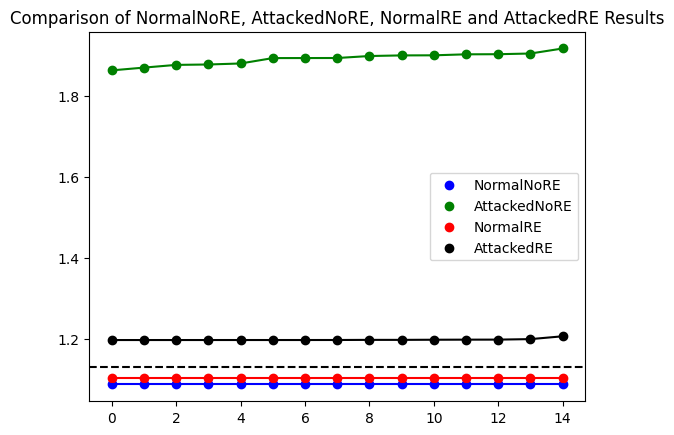

In [20]:
import matplotlib.pyplot as plt

AttackedNoRE_res_list.sort()
AttackedRE_res_list.sort()
NormalRE_res_list.sort()

colors = ['blue', 'green', 'red', 'black']

plt.scatter(range(len(NormalNoRE_res_list)), NormalNoRE_res_list, color=colors[0], label='NormalNoRE')
plt.plot(range(len(NormalNoRE_res_list)), NormalNoRE_res_list, color=colors[0])

plt.scatter(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color=colors[1], label='AttackedNoRE')
plt.plot(range(len(AttackedNoRE_res_list)), AttackedNoRE_res_list, color=colors[1])

plt.scatter(range(len(NormalRE_res_list)), NormalRE_res_list, color=colors[2], label='NormalRE')
plt.plot(range(len(NormalRE_res_list)), NormalRE_res_list, color=colors[2])

plt.scatter(range(len(AttackedRE_res_list)), AttackedRE_res_list, color=colors[3], label='AttackedRE')
plt.plot(range(len(AttackedRE_res_list)), AttackedRE_res_list, color=colors[3])

plt.axhline(y=threshold, color='black', linestyle='--')

plt.legend()
plt.title('Comparison of NormalNoRE, AttackedNoRE, NormalRE and AttackedRE Results')

plt.savefig(f'cyber_result/true_L1/{noise_type}/Comparison4.png')